<a href="https://colab.research.google.com/github/AndyMDH/pneumonia_detection_cnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506  End of Module: Automated Pneumonia Detection: Convolutional Neural Network Approach



## **Table of Contents**
1. [Introduction](#section-1)
2. [Exploratory Data Analysis](#section-2)
3. [Data Preprocessing and Augmentation](#section-3)
4. [3-Layer CNN Architecture Development and Observations](#section-4)
5. [2-Layer CNN Architecture Development and Observations](#section-5)
6. [Hyperparameter Tuning](#section-6)
7. [Model Evaluation](#section-7)
8. [References](#section-8)

---
## **Introduction**


### **Import Dependencies**

Pneumonia poses a severe threat to human health, being a potentially life-threatening infectious illness that typically affects one or both lungs. It is frequently triggered by bacteria, notably Streptococcus pneumoniae. According to the World Health Organization (WHO), pneumonia is responsible for one in three deaths in India (Varshni et al., 2019). Medical practitioners often rely on X-ray scans to diagnose pneumonia, distinguishing between bacterial and viral types.

This Jupyter notebook delves into the realm of automated pneumonia detection using Convolutional Neural Networks (CNNs). Specifically, it addresses the task of training a CNN model to differentiate between healthy lung scans and those afflicted with pneumonia. The dataset utilised for this endeavor is sourced from the Kaggle competition repository, offering a collection of chest X-ray images categorised as pneumonia-positive and normal.


**This task involves, but is not limited to:**

a. CNN Model Development:

- Write code to train a CNN model using the provided dataset.
- Objective: Achieve optimal performance in distinguishing between healthy and pneumonia-infected lung images.

    - **Key considerations:**
      - Define CNN architecture, including convolution-pooling blocks.
      - Fine-tune parameters like strides, padding, and activation functions for accuracy.
      - Implement strategies to prevent overfitting and ensure model generalization.

b. Training and Evaluation:

- Train the CNN model using the provided training dataset.
Fine-tune hyperparameters using validation data to enhance performance.
- Evaluate the model's accuracy using a separate test dataset to validate pneumonia detection in chest X-ray images.

This Jupyter Notebook was collaboratively prepared by:

- Minh-Dat Andy Ho Huu
- Santiago Fernandez Blanco
- Ismael Saumtally
- Chi Chuen Wan
- Chui Yi Wong

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [2]:
# Standard library imports
import json
import logging
import os
import random
import shutil
import time
import warnings
from zipfile import ZipFile

# Related third-party imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


from keras_tuner import HyperParameters, Hyperband
from kerastuner.tuners import RandomSearch

# Local application/library specific imports
from google.colab import drive

# Warnings configuration
warnings.filterwarnings('ignore')


<ipython-input-2-c67fa2fd795d>:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. If you don't have a GPU, set this to False.

In [3]:
USE_CUDA = True

In [4]:
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

---
### **Download Pneumonia Dataset**

The dataset can be downloaded here: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)

In [5]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

**Load Dataset into DataFrame from Google Drive**

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

# Defining dataset directory
DATASET_DIR = "/content/drive/MyDrive/Liverpool/CSCK506 Deep Learning/End of Module/archive/chest_xray"
train_dir = DATASET_DIR + "/train"
val_dir = DATASET_DIR + "/val"
test_dir = DATASET_DIR + "/test"

if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
    print("Dataset directories exist.")
else:
    print("One or more dataset directories are not found. Please recheck the file locations.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directories exist.


##### **Alternatively**, if you're running this notebook from your local machine, you can open, uncomment, and run the code block below to download and unzip the x-ray files from Kaggle.

In [7]:
# def download_file(url, destination):
#     try:
#         urllib.request.urlretrieve(url, destination)
#         logger.info(f'Downloaded file from {url} to {destination}')
#     except Exception as e:
#         logger.error(f'Error downloading file: {e}')

# def extract_zip(zip_path, extract_path):
#     try:
#         with ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         logger.info(f'Extracted {zip_path} to {extract_path}')
#     except Exception as e:
#         logger.error(f'Error extracting zip file: {e}')

# def create_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         logger.info(f'Created directory: {directory}')

# DATASET_NAME = 'chest_x_ray'
# DATASET_URL = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download'
# DATASET_DIR = os.path.join(DATASET_NAME)
# DATASET_ZIP = os.path.join(DATASET_DIR, 'archive.zip')

# # Check if dataset directory already exists
# if os.path.exists(DATASET_DIR):
#     print(f'{DATASET_NAME} already exists')
# else:
#     if os.path.exists(DATASET_ZIP):
#         create_directory(DATASET_DIR)
#         extract_zip(DATASET_ZIP, CORPUS_DIR)
#         os.remove(DATASET_ZIP)
#         print(f'{DATASET_URL_NAME} extracted')
#     else:
#         print(f'To obtain the "{DATASET_NAME}" dataset, please follow these steps:')
#         print(f'1. Manually download the Chest X-Ray dataset from: {DATASET_URL}')
#         print(f'2. Place the downloaded "archive.zip" file in the "{DATASET_DIR}" folder.')
#         print(f'3. Rerun this script after placing the corpus in the correct location.')


---
## **Exploratory Data Analysis**

Processing Train dataset...
Image counts for Train: {'NORMAL': 3875, 'PNEUMONIA': 3875}


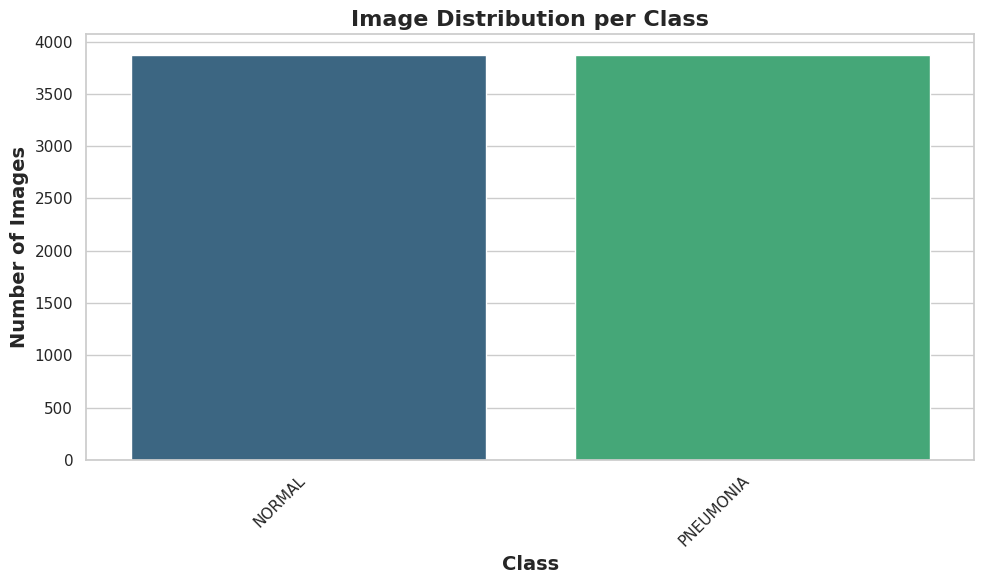

Processing Validation dataset...
Image counts for Validation: {'PNEUMONIA': 8, 'NORMAL': 8}


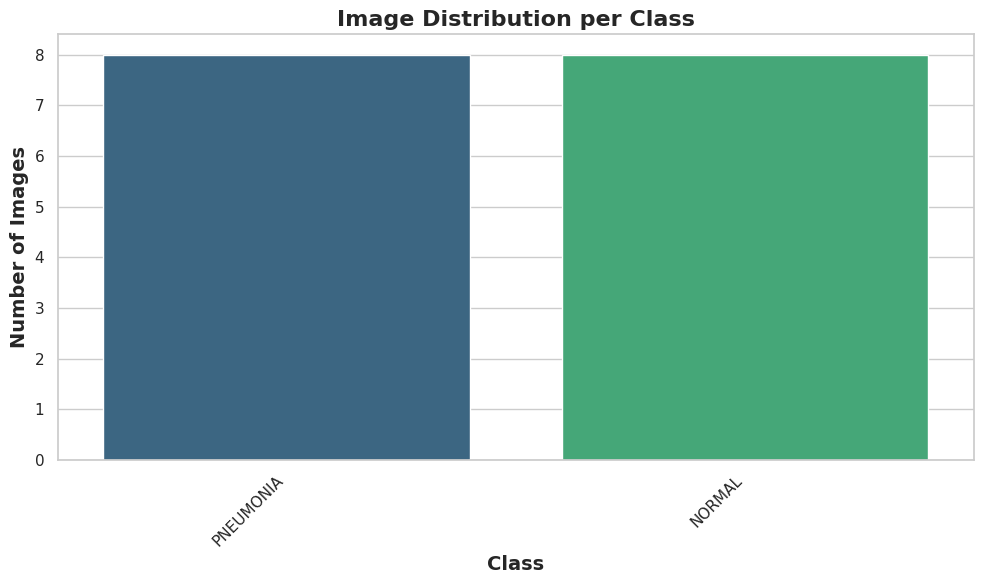

Processing Test dataset...
Image counts for Test: {'PNEUMONIA': 390, 'NORMAL': 234}


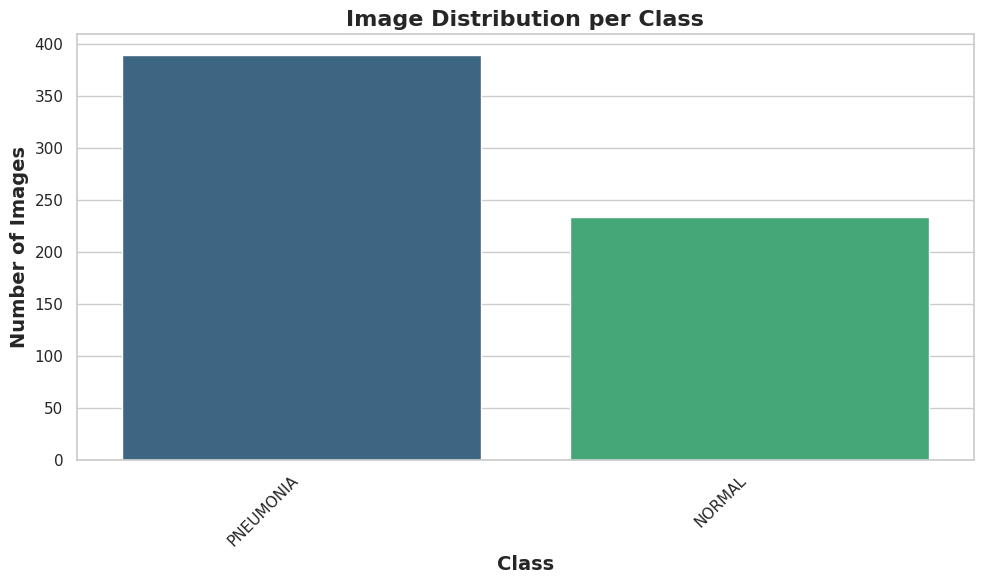

In [8]:
def count_images(dir_path):
    """
    Counts the number of images in each subdirectory for the given directory path.
    """
    counts = {}
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

def visualize_counts(counts_dict):
    """
    Visualizes the image counts using a bar chart.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
    plt.title('Image Distribution per Class', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

DATASET_DIRS = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir
}

for dataset_name, dir_path in DATASET_DIRS.items():
    print(f"Processing {dataset_name} dataset...")
    counts = count_images(dir_path)
    print(f"Image counts for {dataset_name}: {counts}")
    visualize_counts(counts)

Given the restrictive size of our validation set, comprising only 16 images total, we made a strategic decision to exclude it from our model evaluation process. This choice was driven by the recognition that such a diminutive dataset would likely yield unreliable performance estimates and hinder our ability to effectively gauge model generalisation.

Our thought process, being:

*  **Inadequate Representation:** The minuscule size of the validation set makes it inherently unrepresentative of the broader dataset and difficult in detecting overfitting. Its limited diversity fails to encapsulate the full spectrum of variability present in the dataset, rendering performance evaluations susceptible to bias.

*  **Unreliable Performance Metrics:** Evaluating model performance on a meagre validation set may yield erratic and unreliable performance metrics. The inherent randomness in neural network training, combined with the small sample size, exacerbates the variability in performance estimates.


In [9]:
def display_sample_images(dir, class_, num_samples=3):
    class_dir = os.path.join(dir, class_)
    sample_images = random.sample(os.listdir(class_dir), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for ax, image in zip(axes, sample_images):
        img_path = os.path.join(class_dir, image)
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

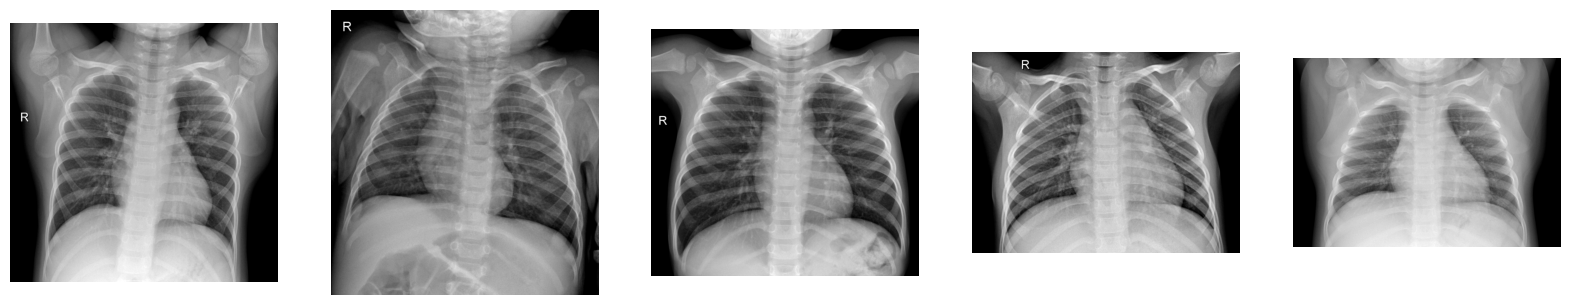

In [10]:
display_sample_images(train_dir, 'NORMAL', 5)

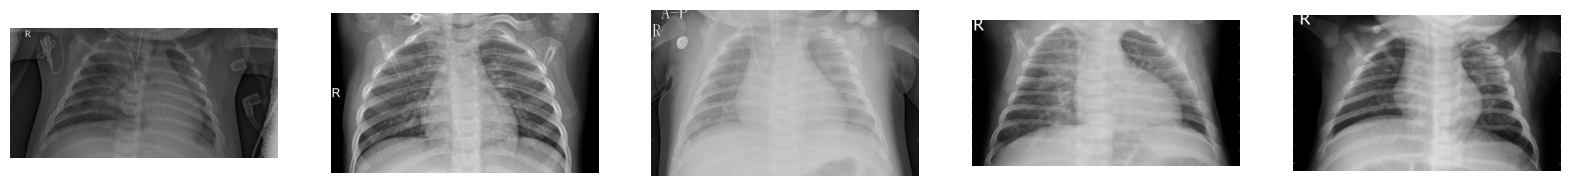

In [11]:
display_sample_images(train_dir, 'PNEUMONIA', 5)

---
## **Data Preprocessing & Augmentation**


#### **Addressing Data Imbalance**

Oversampling enhances model accuracy and fairness by providing a balanced class distribution, allowing models to learn more representative features of underrepresented classes. It is a straightforward and flexible method that can be easily integrated into most data preprocessing pipelines, offering improved model generalization on unseen data.

Additionally, performing oversampling before augmentation helps maintain the natural distribution of classes within the augmented data. If augmentation were done first, the augmented data might disproportionately represent the original class distributions, potentially amplifying existing imbalances rather than mitigating them.

In [8]:
# Function to oversample minority class in a given directory
def oversample_classes(train_dir):
    classes = os.listdir(train_dir)

    # Determine the maximum number of images in any class
    max_count = 0
    for _class in classes:
        class_path = os.path.join(train_dir, _class)
        count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        if count > max_count:
            max_count = count

    # Oversample other classes to match 'max_count'
    for _class in classes:
        class_path = os.path.join(train_dir, _class)
        images = [name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))]
        count = len(images)
        if count < max_count:
            extra_imgs = resample(images, replace=True, n_samples=(max_count - count))
            for img_name in extra_imgs:
                # Copy the oversampled images to the class directory with a unique name
                src = os.path.join(class_path, img_name)
                dst = os.path.join(class_path, f"copy_{os.path.splitext(img_name)[0]}_{time.time()}{os.path.splitext(img_name)[1]}")
                shutil.copy(src, dst)

# Perform oversampling for the training directory
oversample_classes(train_dir)

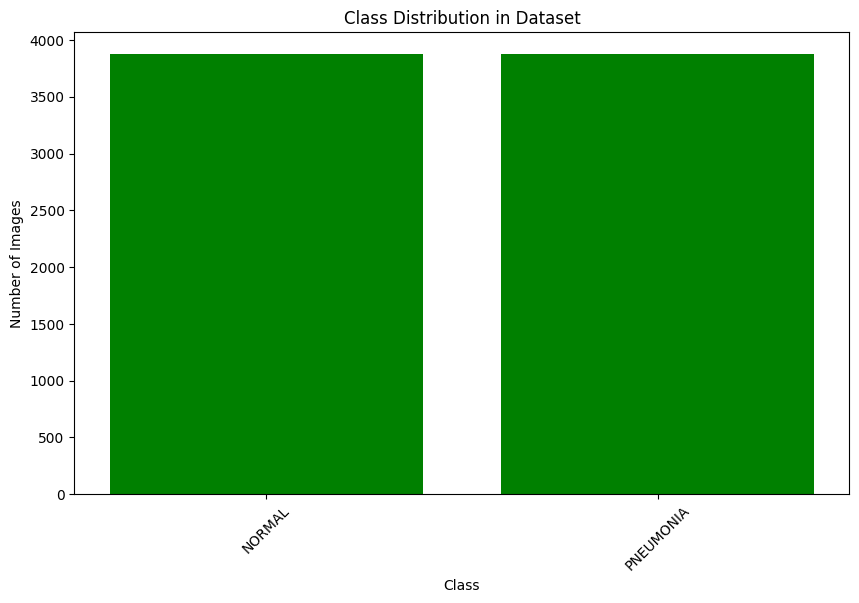

In [9]:
def plot_class_distribution(directory):
    # List to store class names and image counts
    classes = []
    image_counts = []

    # Iterate over each class directory in the dataset directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        # Count the number of files (assuming they are all images)
        count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
        classes.append(class_name)
        image_counts.append(count)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, image_counts, color='green')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Plot class distribution for the training directory
plot_class_distribution(train_dir)

#### **Implementing Callbacks**

**EarlyStopping:** By monitoring the validation loss and specifying a patience of 12 epochs, training will halt if the validation loss does not improve for 12 consecutive epochs. This means the model stops training when it no longer makes significant progress, avoiding the waste of computing power on further training that does not yield improvements and preventing the model from learning noise in the training data.

**ModelCheckpoint:** The ModelCheckpoint callback is used to save the model at its best state, specifically when it achieves the lowest validation loss. This is crucial for ensuring that the version of the model retained at the end of training is the one that performs best on the validation set, rather than the last set of weights achieved by the end of training, which may not be the best due to overfitting or other issues.

**ReduceLROnPlateau:** The ReduceLROnPlateau callback dynamically adjusts the learning rate, a crucial hyperparameter for training deep learning models. By reducing the learning rate by a factor of 0.2 after the validation loss fails to improve for 5 epochs, this callback helps in fine-tuning the model's weights more delicately, potentially escaping local minima and making progress when stuck.

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min'),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='min'),
    ModelCheckpoint('checkpoint_epoch_{epoch}.h5', save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, mode='min', verbose=1)
]

#### **Data Augmentation**

In our data preparation for model training, we integrate data augmentation techniques to fortify the resilience and generalisation capability of our image classification model.

The **create_augmented_data_generator** function, utilising the ImageDataGenerator class, applies diverse transformations such as rotation, shifts, and flipping to enhance the training dataset. This augmentation amplifies dataset diversity, thereby enhancing the model's ability to generalise to unseen data.

Moreover, we standardise the pixel values of our images from the original 0 to 255 range to a normalised range of 0 to 1 by dividing each pixel by 255. This normalisation step is crucial for maintaining numerical stability and expediting the model's learning process, aligning with the input format typically expected by neural networks.All input images are resized to dimensions of 300x300 to ensure a consistent contribution to the model's learning process. This dimensionality choice is pragmatic, conserving computational resources while retaining sufficient image detail for accurate classification.

Additionally, by setting **class_mode='binary'**, the data generator expects subdirectories in the train_dir directory, each representing a class, and assigns labels accordingly. In our instance, the classes and directories are 'NORMAL' and 'PNEUMONIA' with the label 0 and 1.

In [11]:
ROTATION_RANGE = 10
WIDTH_SHIFT_RANGE = 0.05
HEIGHT_SHIFT_RANGE = 0.05
HORIZONTAL_FLIP = True
FILL_MODE = 'nearest'
TARGET_SIZE = (300, 300)
RESCALE = 1. / 255.
BATCH_SIZE = 32

def create_augmented_data_generator(train_dir):
    """
    Create a data generator for training images with augmentation.

    Args:
        train_dir (str): Path to the directory containing training images.

    Returns:
        DirectoryIterator: Data generator for training images with augmentation.
    """
    train_datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        fill_mode=FILL_MODE,
        rescale=RESCALE
    )

    train_data_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return train_data_generator

def create_test_data_generator(test_dir):
    """
    Create a data generator for test images without augmentation.

    Args:
        test_dir (str): Path to the directory containing test images.

    Returns:
        DirectoryIterator: Data generator for test images without augmentation.
    """
    test_datagen = ImageDataGenerator(rescale=RESCALE)

    test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return test_data_generator

In [12]:
# Call the function to create augmented data generator for training set
train_data_generator = create_augmented_data_generator(train_dir)

# Call the function to create data generator for test set
test_data_generator = create_test_data_generator(test_dir)

Found 7750 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


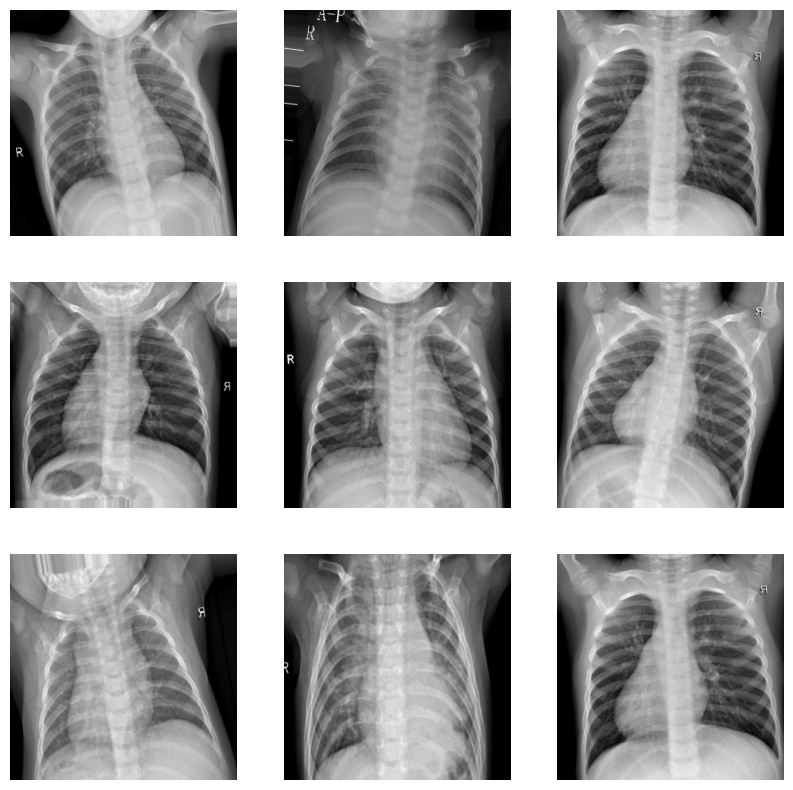

In [13]:
# Display the first 9 image samples of the batch after pre-processing
for i, (images, labels) in enumerate(train_data_generator):
    if i == 1:
        break
    plt.figure(figsize=(10, 10))
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j])
        plt.axis("off")

---
## **3-Layer CNN Architecture Development and Observations**

In [18]:
model_1 = tf.keras.models.Sequential([
    # Initialise the input layer with the input shape
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), input_shape=(300, 300,3), name="First_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.2, name='Dropout_1'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Middle convolutional layers to extract features
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), name="Second_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.2, name='Dropout_2'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Last convolutional layers to extract higher level features
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2), name="Third_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_3'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

    # Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

**Layer 1:** The first convolutional layer employs 32 (3x3) filters, initiating feature extraction from 300x300 pixel inputs by detecting low-level features such as edges and textures through convolution, utilizing a (2,2) stride and 'same' padding for spatial dimensionality reduction.

**Layer 2:** The subsequent layer enhances complexity with 64 (3x3) filters, further abstracting features with the same stride and padding, improving the model's ability to identify intricate visual patterns.

**Layer 3:** The third layer, with 128 (3x3) filters, deepens feature extraction, capturing more complex patterns and reducing spatial dimensions, still using a (2,2) stride and 'same' padding.

Implementing L2 regularization alongside dropout serves as an effective strategy for mitigating overfitting. L2 regularisation introduces a penalty proportional to the square of the weight magnitudes (L2 norm), fostering smaller weights and thereby simplifying the model.

The synergistic effect of dropout and L2 regularization addresses overfitting through complementary mechanisms:

* Dropout combats overfitting by randomly deactivating a portion of the neurons during training, compelling the model to adapt by developing more generalizable features. This randomness ensures the model does not rely too heavily on any single feature or neuron, enhancing its robustness.

* L2 regularisation limits the model's complexity by penalizing large weights, preventing the model from becoming overly sensitive to the training data. This penalty to the loss function encourages a more distributed weight configuration, reducing the model's dependence on any specific high-magnitude weights and promoting a more balanced feature importance.

In [19]:
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Convolution (Conv2D)  (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 Dropout_1 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 Second_Convolution (Conv2D  (None, 38, 38, 64)        1

#### **Training & Performance Insights for 3-Layer CNN**

In [ ]:
# Start timing
start_time = time.time()

history = model_1.fit(train_data_generator,
                      epochs=30,
                      validation_data=test_data_generator,
                      callbacks=callbacks)

# End timing
end_time = time.time()

# Calculate the duration
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/30
243/243 [==============================] - ETA: 0s - loss: 0.9833 - accuracy: 0.9040 

In [ ]:
def plot_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Training ' + metric.capitalize(), color='blue', linestyle='-')
    plt.plot(history.history['val_' + metric], label='Validation ' + metric.capitalize(), color='orange', linestyle='--')
    plt.title('Model ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

In [ ]:
# Load the best epoch model saved by ModelCheckpoint callback
model_1 = tf.keras.models.load_model('best_model.h5')

train_loss, train_accuracy = model_1.evaluate(train_data_generator)
print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model_1.evaluate(test_data_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

#### **Model Observations**

**Epoch 1 - 30:**

* **Model Train Time:** 06:15:56 hours
* **Training Accuracy:** Gradual increase from 90.67%% to 98.84%%.
* **Training Loss:** Shows a consistent decrease from 1.0019 to 0.0464.
* **Validation Accuracy:** Fluctuates with a general upward trend, starting from 62.50% and reaching a high of 89.10%.
* **Validation Loss:** Exhibits volatility with overall downward trend, starting from 2.206 and achieving lows such as 0.3176.



**Training and Validation Trends:** Throughout the training epochs, the model consistently improved in terms of training loss and accuracy, demonstrating effective learning from the training dataset. However, the validation loss and accuracy exhibited some fluctuations, raising small concerns about the model's ability to generalise well to unseen data.

**Model Checkpoint Utilisation**: To combat the observed fluctuations in validation performance, employing a model checkpoint strategy enables the selection of the best-performing model iteration based on validation accuracy. This approach ensures that, despite fluctuations, the model saved for deployment is the one that achieved the highest accuracy on the validation set.

---
## **2-Layer CNN Architecture Development and Observations**

In [ ]:
# Second CNN model with two convolutional layers
model_2 = tf.keras.models.Sequential([
    # Initialise the input layer with the input shape
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), input_shape=(300, 300,3), name="First_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_1'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolutional layers to extract features
    tf.keras.layers.Conv2D(128, (2, 2), padding='same', strides=(2, 2), name="Second_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_2'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(rate=0.5, name='Dropout_dense_1'),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

    # Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
print(model_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Convolution (Conv2D)  (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 150, 150, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 64)      0         
                                                                 
 Dropout_1 (Dropout)         (None, 150, 150, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 Second_Convolution (Conv2D  (None, 38, 38, 128)       3

#### **Model 2 Training**

In [ ]:
# Start timing
start_time = time.time()

history = model_2.fit(train_data_generator,
                    epochs=30,
                    validation_data=test_data_generator,
                    callbacks=callbacks)

# End timing
end_time = time.time()

# Calculate the duration
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/30
 14/243 [>.............................] - ETA: 39:20 - loss: 12.4398 - accuracy: 0.5357

In [ ]:
plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

#### **Training & Performance Insights for 2-Layer CNN**



In [ ]:
# Load the best model saved by ModelCheckpoint callback
model = tf.keras.models.load_model('best_model.h5')

train_loss, train_accuracy = model.evaluate(train_data_generator)
print("Training loss:", train_loss)
print("Training accuracy:", train_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

#### **Model Observations**

**Epoch 1 - 30:**

* **Model Train Time:** 06:15:56 hours
* **Training Accuracy:** Gradual increase from 90.67%% to 98.84%%.
* **Training Loss:** Shows a consistent decrease from 1.0019 to 0.0464.
* **Validation Accuracy:** Fluctuates with a general upward trend, starting from 62.50% and reaching a high of 89.10%.
* **Validation Loss:** Exhibits volatility with overall downward trend, starting from 2.206 and achieving lows such as 0.3176.



**Training and Validation Trends:** Throughout the training epochs, the model consistently improved in terms of training loss and accuracy, demonstrating effective learning from the training dataset. However, the validation loss and accuracy exhibited some fluctuations, raising small concerns about the model's ability to generalise well to unseen data.

**Model Checkpoint Utilisation**: To combat the observed fluctuations in validation performance, employing a model checkpoint strategy enables the selection of the best-performing model iteration based on validation accuracy. This approach ensures that, despite fluctuations, the model saved for deployment is the one that achieved the highest accuracy on the validation set.

---
## **Hyperparameter Tuning**


Hyperparameter tuning through **Keras** Tuner streamlines the optimisation of our model architecture by methodically identifying the ideal configuration of training parameters, and should enhance model performance. This structured approach automates the trial-and-error process, crucially saving time and resources while meticulously exploring an extensive parameter space.

In [14]:
def build_model(hp):
    model = Sequential([
        # Input layer with dynamic number of filters and kernel size
        Conv2D(hp.Int('conv_1_filters', min_value=16, max_value=48, step=16),
               hp.Choice('conv_1_kernel', values=[3, 5]), padding='same', strides=(2, 2),
               input_shape=(300, 300, 3), name="First_Convolution"),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.05), name='Dropout_1'),
        MaxPooling2D(2, 2),

        # Middle convolutional layer with dynamic number of filters and kernel size
        Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=64, step=32),
               hp.Choice('conv_2_kernel', values=[3, 5]), padding='same', strides=(2, 2), name="Second_Convolution"),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.05), name='Dropout_2'),
        MaxPooling2D(2, 2),

        # Last convolutional layer with dynamic number of filters and kernel size
        Conv2D(hp.Int('conv_3_filters', min_value=64, max_value=128, step=64),
               hp.Choice('conv_3_kernel', values=[3, 5]), padding='same', strides=(2, 2), name="Third_Convolution"),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.4, step=0.05), name='Dropout_3'),
        MaxPooling2D(2, 2),

        # Flatten and dense layers
        Flatten(),
        Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu',
              kernel_regularizer=l2(hp.Float('l2_regularization', min_value=1e-4, max_value=1e-2, sampling='LOG'))),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with a dynamic learning rate
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])

    return model

Key Steps During Hyperparameter Tuning:
* **Dynamic Convolutional Layers:** Introduced variability in the number of filters and kernel sizes across the convolutional layers, enabling the model to explore different feature extraction capabilities.
* **Adjustable Dropout Rates:** Specified ranges for dropout rates to dynamically regulate neuron activity and mitigate overfitting, enhancing the model's ability to generalise.
* **Flexible Dense Layer Configuration:** Tuned the neuron count in dense layers and the degree of L2 regularization, aiming to optimize the model’s processing and interpretation of features.
* Learning Rate Optimisation: Experimented with different learning rates to find the optimal speed of convergence, crucial for achieving high model performance.
* **Compilation and Evaluation**: Compiled the model with a binary cross-entropy loss function and an Adam optimiser, incorporating hyperparameter choices to systematically evaluate model performance across configurations.

In [15]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=6,
    factor=3,
    directory='keras_tuner_dir',
    project_name='cnn_project'
)

In [ ]:
tuner.search(
    train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    epochs=6,
    validation_data=test_data_generator,
    validation_steps=test_data_generator.samples // test_data_generator.batch_size,
    callbacks=callbacks
)

# Calculate and print the duration
search_time = end_time - start_time
print(f"Hyperparameter search time: {search_time} seconds")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |conv_1_filters
5                 |5                 |conv_1_kernel
0.15              |0.15              |dropout_1
64                |64                |conv_2_filters
5                 |5                 |conv_2_kernel
0.2               |0.2               |dropout_2
128               |128               |conv_3_filters
5                 |5                 |conv_3_kernel
0.2               |0.2               |dropout_3
1024              |1024              |dense_units
0.00053012        |0.00053012        |l2_regularization
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 26/242 [==>...........................] - ETA: 20:30 - loss: 2.1970 - accuracy: 

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Summary of the best model
best_model.summary()

In [ ]:
def plot_comparison(history_original, history_tuned, metric='accuracy'):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_original.history[metric], label='Original')
    plt.plot(history_tuned.history[metric], label='Tuned')
    plt.title(f'Training {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_original.history[f'val_{metric}'], label='Original')
    plt.plot(history_tuned.history[f'val_{metric}'], label='Tuned')
    plt.title(f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming history_tuned is the training history of the best model from Keras Tuner
plot_comparison(history_original, history_tuned)


---
## **Model Evaluation**

In [ ]:
# Calculate percentages for confusion matrix
total_samples = len(actual_labels)
percentages = confusion_matrix / total_samples * 100

# Extracting TP, FP, TN, FN
TP = confusion_matrix[1, 1]
FP = confusion_matrix[0, 1]
TN = confusion_matrix[0, 0]
FN = confusion_matrix[1, 0]

# Plot confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(percentages, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])



In [ ]:
def visualize_predictions(image_batch, actual_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(len(image_batch), size=min(num_images, len(image_batch)), replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(image_batch[idx])
        actual = 'Negative' if actual_labels[idx] == 0 else 'Positive'
        predicted = 'Negative' if predicted_labels[idx] == 0 else 'Positive'
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis("off")
    plt.show()

In [ ]:
image_batch, label_batch = next(iter(test_data_generator))
label_batch_int = label_batch.astype(int)
predicted_labels_batch = np.round(predictions[:len(image_batch)]).astype(int).flatten()
visualize_predictions(image_batch, label_batch_int, predicted_labels_batch)

#### **Saving CNN Model**

In [ ]:
# Save the model in SavedModel format
best_model.save('C:\Users\andyh\Downloads')

In [ ]:
# Convert the hyperparameters to a dictionary
hp_dict = best_hyperparameters.values

# Save to a JSON file
with open('C:\Users\andyh\Downloads\best_hyperparameters.json', 'w') as f:
    json.dump(hp_dict, f)

---
## **References:**

*   Ciaburro, Giuseppe. and Venkateswaran, B. (2017) Neural networks with R smart models using CNN, RNN, deep learning, and artificial intelligence principles / Giuseppe Ciabur-ro, Balaji Venkateswaran. 1st ed. S.l: Packt Publishing.
* Kennedy, S. (2022) Types of deep learning & their uses in Healthcare, HealthITAnalytics. Available at: https://healthitanalytics.com/features/types-of-deep-learning-their-uses-in-healthcare (Accessed: 26 February 2024).
* Kermany, D., Zhang, K. and Goldbaum, M. (2018). Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. data.mendeley.com, [online] 2. doi:https://doi.org/10.17632/rscbjbr9sj.2.
* Nirmala, K., Saruladha, K. and Dekeba, K. (2022) “Investigations of CNN for Medical Image Analysis for Illness Prediction,” Computational intelligence and neuroscience, 2022, pp. 7968200–13. Available at: https://doi.org/10.1155/2022/7968200.
* Varshni, D., Thakral, K., Agarwal, L., Nijhawan, R. and Mittal, A. (2019). Pneumonia Detection Using CNN based Feature Extraction. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICECCT.2019.8869364.
* Zhou, X., Li, Y. and Liang, W. (2021) “CNN-RNN Based Intelligent Recommendation for Online Medical Pre-Diagnosis Support,” IEEE/ACM transactions on computational biolo-gy and bioinformatics, 18(3), pp. 912–921. Available at: https://doi.org/10.1109/TCBB.2020.2994780.
